In [200]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVC
import torch, torch_geometric
import wandb
import utils
from IPython.display import clear_output
import json
import math

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

import itertools

In [218]:
def get_model_type(x):
    if isinstance(x, str) and x.startswith("1WL+NN"): return "1-WL+NN"
    elif isinstance(x, str) and (x.startswith("GAT") or x.startswith("GIN") or x.startswith("GCN")): return "GNN"
    else: return pd.NA

def get_pool_type(x):
    if isinstance(x, str) and x.endswith("Embedding-Sum"): return "Embedding:Sum"
    elif isinstance(x, str) and x.endswith("Embedding-Max"): return "Embedding:Max"
    elif isinstance(x, str) and x.endswith("Embedding-Mean"): return "Embedding:Mean"
    elif isinstance(x, str) and x.startswith("GAT") and x.endswith("Sum"): return "GAT:Sum"
    elif isinstance(x, str) and x.startswith("GAT") and x.endswith("Max"): return "GAT:Max"
    elif isinstance(x, str) and x.startswith("GAT") and x.endswith("Mean"): return "GAT:Mean"
    elif isinstance(x, str) and x.startswith("GIN") and x.endswith("Sum"): return "GIN:Sum"
    elif isinstance(x, str) and x.startswith("GIN") and x.endswith("Max"): return "GIN:Max"
    elif isinstance(x, str) and x.startswith("GIN") and x.endswith("Mean"): return "GIN:Mean"
    elif isinstance(x, str) and x.startswith("GCN") and x.endswith("Sum"): return "GCN:Sum"
    elif isinstance(x, str) and x.startswith("GCN") and x.endswith("Max"): return "GCN:Max"
    elif isinstance(x, str) and x.startswith("GCN") and x.endswith("Mean"): return "GCN:Mean"
    elif  isinstance(x, str) and x.endswith("Sum"): return "Sum"
    elif isinstance(x, str) and x.endswith("Max"): return "Max"
    elif isinstance(x, str) and x.endswith("Mean"): return "Mean"
    elif isinstance(x, str) and x.endswith("Set2Set"): return "Set2Set"
    else: return pd.NA

api = wandb.Api(timeout=30)

# Project is specified by <entity/project-name>
runs = api.runs("eric-bill/BachelorThesisExperiments")

dist_data = []
for run in runs:
    if run.state == "finished":
        dist_data.append(run.summary._json_dict | run.config | {'config' : str(run._attrs['config'])} |
                    {'Tags' : run.tags[0] if len(run.tags) > 0 else pd.NA} | {'name' : run.name, 'run_id' : run.id})

runs_df = pd.DataFrame(dist_data)
runs_df['model_type'] = runs_df['model'].apply(get_model_type)
runs_df['pool_type'] = runs_df['model'].apply(get_pool_type)
runs_df.to_csv("project.csv")

In [202]:
def get_acc_and_std(dataset, group_col, acc_col='test_accuracy', std_col='test_accuracy_std', latex=False, min=False):
    data = []

    for (grouping_name, grouping_df) in dataset.groupby(group_col):

        if min:
            best_idx = grouping_df[acc_col].idxmin()
        else:
            best_idx = grouping_df[acc_col].idxmax()
        
        if math.isnan(best_idx):
            continue
        
        acc = grouping_df.loc[best_idx, acc_col]
        std = grouping_df.loc[best_idx, std_col]
        if latex:
            result = f'{acc:.1f} \scriptsize $\pm {std:.1f}$'
        else:
            result = f"{acc:.3f} \u00B1 {std:.3f}"

        data.append({group_col[i] : grouping_name[i] for i in range(len(group_col))} |
                     {acc_col : result, 'run_id' : grouping_df.loc[best_idx, 'run_id']})
    
    return pd.DataFrame(data)

In [203]:
runs_df.pivot_table(index=['model_type', 'pool_type'], 
                                columns='dataset', values=['test_accuracy'], aggfunc=lambda x: len(x))

test_accuracy                                   \
dataset                      Alchemy10K ENZYMES IMDB-BINARY  MUTAG  NCI1   
model_type pool_type                                                       
1-WL+NN    Embedding:Max           95.0   183.0       275.0  185.0  43.0   
           Embedding:Mean          80.0   141.0       263.0  177.0  69.0   
           Embedding:Sum          276.0   134.0       286.0  191.0  51.0   
           Max                      NaN    86.0        70.0  150.0  26.0   
           Mean                     NaN    76.0        67.0  120.0  19.0   
           Sum                      NaN    85.0        67.0  130.0  14.0   
GNN        GAT:Max                  NaN    17.0        17.0   36.0  11.0   
           GAT:Mean                 NaN    28.0        15.0   28.0  12.0   
           GAT:Sum                  NaN    26.0        17.0   37.0  15.0   
           GCN:Max                  NaN    31.0        22.0   37.0  17.0   
           GCN:Mean                 NaN    19.0        26.0   26.0  19.0   
           GCN:Sum                  NaN    30.0        29.0   27.0  17.0   
           GIN:Max                  NaN    21.0        17.0   28.0  25.0   
           GIN:Mean                 NaN    31.0         9.0   31.0  18.0   
           GIN:Sum                  NaN    26.0         9.0   38.0  20.0   

                                                                
dataset                   PROTEINS REDDIT-BINARY Zinc Zinc 10k  
model_type pool_type                                            
1-WL+NN    Embedding:Max     180.0          25.0  3.0     33.0  
           Embedding:Mean    167.0          30.0  2.0     24.0  
           Embedding:Sum     156.0          21.0  1.0     18.0  
           Max                35.0          40.0  NaN      NaN  
           Mean               27.0          40.0  NaN      NaN  
           Sum                29.0          41.0  NaN      NaN  
GNN        GAT:Max            10.0           6.0  NaN      NaN  
           GAT:Mean           10.0           6.0  NaN      NaN  
           GAT:Sum            16.0           6.0  NaN      NaN  
           GCN:Max            10.0           9.0  NaN      NaN  
           GCN:Mean           16.0           5.0  NaN      NaN  
           GCN:Sum            14.0           9.0  NaN      NaN  
           GIN:Max            20.0           3.0  NaN      NaN  
           GIN:Mean           26.0           9.0  NaN      NaN  
           GIN:Sum            11.0           9.0  NaN      NaN

In [204]:
latex_table = get_acc_and_std(runs_df, group_col=['model_type', 'pool_type', 'dataset'], acc_col='test_accuracy', std_col='test_accuracy_std', latex=False)
latex_table = latex_table.pivot_table(index=['model_type', 'pool_type'], 
                                      columns='dataset', values=['test_accuracy'], aggfunc=lambda x: x)
latex_table

test_accuracy                                   \
dataset                           ENZYMES     IMDB-BINARY            MUTAG   
model_type pool_type                                                         
1-WL+NN    Embedding:Max   40.500 ± 7.364  69.380 ± 4.899  81.146 ± 11.226   
           Embedding:Mean  42.600 ± 9.024  72.400 ± 4.056   84.140 ± 9.078   
           Embedding:Sum   48.267 ± 8.109  72.000 ± 3.839   85.117 ± 8.614   
           Max             16.700 ± 4.172  51.980 ± 5.274  73.819 ± 12.434   
           Mean            18.167 ± 4.847  59.440 ± 5.793  77.094 ± 11.517   
           Sum             18.033 ± 6.215  57.480 ± 5.092  66.784 ± 13.904   
GNN        GAT:Max         31.200 ± 5.958  70.720 ± 4.807  71.105 ± 12.182   
           GAT:Mean        28.933 ± 5.926  70.940 ± 3.733   74.801 ± 9.136   
           GAT:Sum         34.400 ± 6.997  72.200 ± 4.540  82.117 ± 11.155   
           GCN:Max         33.067 ± 7.464  73.520 ± 4.097  74.462 ± 11.328   
           GCN:Mean        29.867 ± 5.673  74.680 ± 3.841  75.000 ± 10.423   
           GCN:Sum         31.733 ± 7.182  73.020 ± 4.354  81.520 ± 10.314   
           GIN:Max         29.200 ± 6.193  70.800 ± 4.712  77.322 ± 10.678   
           GIN:Mean        31.733 ± 6.700  71.100 ± 5.430   82.421 ± 9.772   
           GIN:Sum         28.900 ± 8.661  69.460 ± 4.841   84.573 ± 8.711   

                                                                           
dataset                              NCI1        PROTEINS   REDDIT-BINARY  
model_type pool_type                                                       
1-WL+NN    Embedding:Max   82.740 ± 2.040  75.197 ± 3.917  71.110 ± 3.900  
           Embedding:Mean  83.100 ± 1.934  72.682 ± 4.584  75.450 ± 2.782  
           Embedding:Sum   83.601 ± 2.180  75.180 ± 4.463  78.450 ± 2.728  
           Max             58.555 ± 3.267  62.904 ± 4.935  69.200 ± 4.030  
           Mean            64.034 ± 3.263  60.950 ± 4.531  66.090 ± 3.167  
           Sum             56.949 ± 3.827  65.582 ± 4.753  73.000 ± 5.082  
GNN        GAT:Max         58.010 ± 4.209  72.537 ± 5.066  77.720 ± 5.004  
           GAT:Mean        66.088 ± 2.793  64.916 ± 6.374  70.030 ± 6.907  
           GAT:Sum         69.820 ± 2.569  73.434 ± 3.907  78.100 ± 4.206  
           GCN:Max         61.061 ± 3.581  69.792 ± 5.871  74.340 ± 4.461  
           GCN:Mean        68.934 ± 2.417  70.920 ± 5.233  82.300 ± 3.335  
           GCN:Sum         70.380 ± 2.114  73.887 ± 4.008  86.920 ± 3.187  
           GIN:Max         79.859 ± 2.224  74.281 ± 5.073  76.050 ± 3.633  
           GIN:Mean        71.299 ± 2.185  71.965 ± 4.039  73.460 ± 3.783  
           GIN:Sum         70.842 ± 2.320  73.200 ± 4.328  74.020 ± 4.331

In [205]:
latex_table = get_acc_and_std(runs_df, group_col=['model_type', 'pool_type', 'dataset'], acc_col='test_error', std_col='test_error_std',
                               latex=False, min=True)
latex_table = latex_table.pivot_table(index=['model_type', 'pool_type'], 
                                      columns='dataset', values=['test_error'], aggfunc=lambda x: x)
latex_table

test_error                              
dataset                       Alchemy10K           Zinc       Zinc 10k
model_type pool_type                                                  
1-WL+NN    Embedding:Max   0.409 ± 0.003  0.382 ± 0.005  0.659 ± 0.007
           Embedding:Mean  0.355 ± 0.004  0.417 ± 0.012  0.484 ± 0.009
           Embedding:Sum   0.305 ± 0.001            NaN  0.465 ± 0.009

In [206]:
runs_df.pivot_table(index=['model_type'], 
                                columns='dataset', values=['test_accuracy'], aggfunc=lambda x: len(x))

test_accuracy                                             \
dataset       Alchemy10K ENZYMES IMDB-BINARY  MUTAG   NCI1 PROTEINS   
model_type                                                            
1-WL+NN            451.0   705.0      1028.0  953.0  222.0    594.0   
GNN                  NaN   229.0       161.0  288.0  154.0    133.0   

                                        
dataset    REDDIT-BINARY Zinc Zinc 10k  
model_type                              
1-WL+NN            197.0  6.0     75.0  
GNN                 62.0  NaN      NaN

In [207]:
latex_svm = get_acc_and_std(runs_df[runs_df['Tags'] == 'replicate_run'], group_col=['model_type', 'pool_type', 'dataset'],
                             acc_col='test_accuracy', std_col='test_accuracy_std')
latex_svm = latex_svm.pivot_table(index=['model_type', 'pool_type'], 
                                      columns='dataset', values=['run_id'], aggfunc=lambda x: x)
latex_svm

run_id                                          
dataset                     ENZYMES IMDB-BINARY     MUTAG      NCI1  PROTEINS
model_type pool_type                                                         
1-WL+NN    Embedding:Max   60562q4o    rrb09qm5       NaN  kr2efr0t  xwp3x7vc
           Embedding:Mean  ztju6f9s    hsoebyq6       NaN  rvfi5ksh  0wseenmc
           Embedding:Sum   o84jwl99         NaN  vvw0t1se  9c64l23v  yt6edt4n
GNN        GAT:Sum         r0hzi69w         NaN       NaN       NaN       NaN
           GCN:Max         hhc3yspq    423spwqo       NaN       NaN       NaN
           GCN:Mean             NaN    h41v1r4j       NaN       NaN       NaN
           GCN:Sum              NaN    onhuomtj       NaN       NaN  4bkmzbdv
           GIN:Max              NaN         NaN       NaN  ircwl3vt  nor2tequ
           GIN:Mean        6lezhkeo         NaN       NaN  zu2bqs8z  q0nhlr39
           GIN:Sum              NaN         NaN  5z6vl3b3  l7jvcxkk       NaN

In [208]:
latex_svm = get_acc_and_std(runs_df[runs_df['Tags'] == 'replicate_run'], group_col=['model_type', 'pool_type', 'dataset'],
                             acc_col='svm_lin_accuracies', std_col='svm_lin_accuracies_std', latex=True)
latex_svm = latex_svm.pivot_table(index=['model_type', 'pool_type'], 
                                      columns='dataset', values=['svm_lin_accuracies'], aggfunc=lambda x: x)
latex_svm

svm_lin_accuracies  \
dataset                                       ENZYMES   
model_type pool_type                                    
1-WL+NN    Embedding:Max   36.9 \scriptsize $\pm 5.6$   
           Embedding:Mean  37.4 \scriptsize $\pm 6.6$   
           Embedding:Sum   34.4 \scriptsize $\pm 5.5$   
GNN        GAT:Sum         33.2 \scriptsize $\pm 5.9$   
           GCN:Max         37.3 \scriptsize $\pm 6.9$   
           GCN:Mean                               NaN   
           GCN:Sum                                NaN   
           GIN:Max                                NaN   
           GIN:Mean        29.0 \scriptsize $\pm 6.2$   
           GIN:Sum                                NaN   

                                                       \
dataset                                   IMDB-BINARY   
model_type pool_type                                    
1-WL+NN    Embedding:Max   68.9 \scriptsize $\pm 4.8$   
           Embedding:Mean  71.2 \scriptsize $\pm 3.9$   
           Embedding:Sum                          NaN   
GNN        GAT:Sum                                NaN   
           GCN:Max         73.5 \scriptsize $\pm 4.3$   
           GCN:Mean        74.4 \scriptsize $\pm 4.1$   
           GCN:Sum         74.3 \scriptsize $\pm 4.4$   
           GIN:Max                                NaN   
           GIN:Mean                               NaN   
           GIN:Sum                                NaN   

                                                        \
dataset                                          MUTAG   
model_type pool_type                                     
1-WL+NN    Embedding:Max                           NaN   
           Embedding:Mean                          NaN   
           Embedding:Sum    86.4 \scriptsize $\pm 8.9$   
GNN        GAT:Sum                                 NaN   
           GCN:Max                                 NaN   
           GCN:Mean                                NaN   
           GCN:Sum                                 NaN   
           GIN:Max                                 NaN   
           GIN:Mean                                NaN   
           GIN:Sum         58.4 \scriptsize $\pm 35.0$   

                                                       \
dataset                                          NCI1   
model_type pool_type                                    
1-WL+NN    Embedding:Max   82.9 \scriptsize $\pm 1.9$   
           Embedding:Mean  82.7 \scriptsize $\pm 1.8$   
           Embedding:Sum   83.4 \scriptsize $\pm 2.1$   
GNN        GAT:Sum                                NaN   
           GCN:Max                                NaN   
           GCN:Mean                               NaN   
           GCN:Sum                                NaN   
           GIN:Max         67.4 \scriptsize $\pm 2.2$   
           GIN:Mean        69.2 \scriptsize $\pm 2.2$   
           GIN:Sum         70.1 \scriptsize $\pm 3.1$   

                                                       
dataset                                      PROTEINS  
model_type pool_type                                   
1-WL+NN    Embedding:Max   73.9 \scriptsize $\pm 4.1$  
           Embedding:Mean  66.9 \scriptsize $\pm 4.2$  
           Embedding:Sum   74.5 \scriptsize $\pm 4.0$  
GNN        GAT:Sum                                NaN  
           GCN:Max                                NaN  
           GCN:Mean                               NaN  
           GCN:Sum         73.8 \scriptsize $\pm 4.2$  
           GIN:Max         74.7 \scriptsize $\pm 4.2$  
           GIN:Mean        67.7 \scriptsize $\pm 4.4$  
           GIN:Sum                                NaN

In [209]:
latex_rbf = get_acc_and_std(runs_df[runs_df['Tags'] == 'replicate_run'], group_col=['model_type', 'pool_type', 'dataset'],
                             acc_col='svm_rbf_accuracies', std_col='svm_rbf_accuracies_std', latex=True)
latex_rbf = latex_rbf.pivot_table(index=['model_type', 'pool_type'], 
                                      columns='dataset', values=['svm_rbf_accuracies'], aggfunc=lambda x: x)
latex_rbf

svm_rbf_accuracies  \
dataset                                       ENZYMES   
model_type pool_type                                    
1-WL+NN    Embedding:Max   41.2 \scriptsize $\pm 5.8$   
           Embedding:Mean  43.4 \scriptsize $\pm 7.0$   
           Embedding:Sum   45.0 \scriptsize $\pm 7.0$   
GNN        GAT:Sum         35.9 \scriptsize $\pm 6.0$   
           GCN:Max         28.5 \scriptsize $\pm 5.7$   
           GCN:Mean                               NaN   
           GCN:Sum                                NaN   
           GIN:Max                                NaN   
           GIN:Mean        29.4 \scriptsize $\pm 5.9$   
           GIN:Sum                                NaN   

                                                       \
dataset                                   IMDB-BINARY   
model_type pool_type                                    
1-WL+NN    Embedding:Max   69.2 \scriptsize $\pm 5.0$   
           Embedding:Mean  72.8 \scriptsize $\pm 4.3$   
           Embedding:Sum                          NaN   
GNN        GAT:Sum                                NaN   
           GCN:Max         73.0 \scriptsize $\pm 4.2$   
           GCN:Mean        74.6 \scriptsize $\pm 4.6$   
           GCN:Sum         73.6 \scriptsize $\pm 4.1$   
           GIN:Max                                NaN   
           GIN:Mean                               NaN   
           GIN:Sum                                NaN   

                                                       \
dataset                                         MUTAG   
model_type pool_type                                    
1-WL+NN    Embedding:Max                          NaN   
           Embedding:Mean                         NaN   
           Embedding:Sum   83.2 \scriptsize $\pm 7.5$   
GNN        GAT:Sum                                NaN   
           GCN:Max                                NaN   
           GCN:Mean                               NaN   
           GCN:Sum                                NaN   
           GIN:Max                                NaN   
           GIN:Mean                               NaN   
           GIN:Sum         86.0 \scriptsize $\pm 7.4$   

                                                       \
dataset                                          NCI1   
model_type pool_type                                    
1-WL+NN    Embedding:Max   83.1 \scriptsize $\pm 2.0$   
           Embedding:Mean  83.4 \scriptsize $\pm 1.9$   
           Embedding:Sum   83.6 \scriptsize $\pm 1.9$   
GNN        GAT:Sum                                NaN   
           GCN:Max                                NaN   
           GCN:Mean                               NaN   
           GCN:Sum                                NaN   
           GIN:Max         73.0 \scriptsize $\pm 1.9$   
           GIN:Mean        70.2 \scriptsize $\pm 2.0$   
           GIN:Sum         70.9 \scriptsize $\pm 2.3$   

                                                       
dataset                                      PROTEINS  
model_type pool_type                                   
1-WL+NN    Embedding:Max   75.2 \scriptsize $\pm 4.0$  
           Embedding:Mean  73.7 \scriptsize $\pm 4.6$  
           Embedding:Sum   74.5 \scriptsize $\pm 3.8$  
GNN        GAT:Sum                                NaN  
           GCN:Max                                NaN  
           GCN:Mean                               NaN  
           GCN:Sum         73.3 \scriptsize $\pm 4.6$  
           GIN:Max         74.6 \scriptsize $\pm 4.6$  
           GIN:Mean        71.5 \scriptsize $\pm 4.2$  
           GIN:Sum                                NaN

# Distance Matrix

In [554]:
from torch_geometric.utils import degree
from utils import NormalizedDegree
import torch_geometric.transforms as T

dataset_name = 'ENZYMES'

model_gnn = torch.load(f'saved_models/GNN_{dataset_name}.pt')
model_wlnn = torch.load(f'saved_models/WLNN_{dataset_name}.pt')

dataset = model_gnn.dataset
train_index, test_index = model_gnn.train_index, model_gnn.test_index
agg_data = model_gnn.data_aggregate

In [555]:
model_wlnn.config['k_wl'] = 1

In [556]:
from utils import Wrapper_WL_TUDataset, Constant_Long

if dataset._data.x is None:
    print('No node features found. Using constant function for 1WL+NN.')
    dataset.transform = Constant_Long(0)

wl_dataset = Wrapper_WL_TUDataset(dataset, k_wl=model_wlnn.config['k_wl'], wl_convergence=False)

In [557]:
wl_dataset.x.unique(sorted=False)[0]

tensor(230)

In [558]:
if dataset._data.x is None:
    print('No node features found. Using one-hot degree for GNNs.')
    max_degree = 0
    degs = []
    for data in dataset:
        degs += [degree(data.edge_index[0], dtype=torch.long)]
        max_degree = max(max_degree, degs[-1].max().item())

    if max_degree < 1000:
        dataset.transform = T.OneHotDegree(max_degree)
    else:
        deg = torch.cat(degs, dim=0).to(torch.float)
        mean, std = deg.mean().item(), deg.std().item()
        dataset.transform = NormalizedDegree(mean, std)

In [559]:
# Sample 10 random graphs from the test set
indices_graphs = torch.randperm(len(test_index))[:10]
indices_graphs = test_index[indices_graphs]
single_index = test_index[0]

global_error_mean = 0.0
global_error_std = 0.0

X  = None
Y = None

df_dist_matrix = pd.DataFrame()
df_tsne = pd.DataFrame()

with torch.no_grad():
    for idx in test_index:
        num_nodes = dataset[idx].num_nodes
        x_gnn = model_gnn.gnn(dataset[idx].x, dataset[idx].edge_index)
        x_wl = wl_dataset[idx].x

        # Calculate distance matrix
        distance_matrix_gnn = torch.cdist(x_gnn, x_gnn, p=2)
        distance_matrix_gnn = distance_matrix_gnn / distance_matrix_gnn.max() if distance_matrix_gnn.max() > 0 else distance_matrix_gnn
        distance_matrix_wl = torch.sign((x_wl.unsqueeze(1) - x_wl)**2)

        dist_data = pd.DataFrame(list(itertools.product(['GNN Node Representations', '1-WL Colors'], range(0, num_nodes), range(0, num_nodes))), columns=['type', 'i', 'j'])
        dist_data['distance'] = torch.cat([distance_matrix_gnn.flatten(), distance_matrix_wl.flatten()], dim=0).numpy()
        dist_data['idx'] = idx.item()

        error_matrix = (distance_matrix_gnn - distance_matrix_wl).abs()
        dist_data['normed_error'] = f"Graph Index: {idx}\nMAE: {round(error_matrix.mean().item(), 2)} ± {round(error_matrix.std().item(), 2)}"
        global_error_mean += error_matrix.mean().item()
        global_error_std += error_matrix.std().item()

        if X is None and Y is None:
            X = x_gnn
            Y = x_wl
        else:
            X  = torch.cat([X, x_gnn])
            Y = torch.cat([Y, x_wl])

        df_dist_matrix = pd.concat([df_dist_matrix, dist_data], axis=0, ignore_index=True)

print(f'Global normed error: {round(global_error_mean / len(test_index), 2)} ± {round(global_error_std / len(test_index), 2)}')

Global normed error: 0.49 ± 0.3


In [560]:
from sklearn.metrics import f1_score

eps_values = [0.10, 0.05, 0.01, 0.001]

data = []
for eps in eps_values:

    Y_pred = torch.ones_like(Y) * (Y.max() + 1)

    for class_label in Y.unique(sorted=False):

        # Distance matrix between nodes
        sample_indices = torch.argwhere(Y == class_label).squeeze(0)
        X_query = X[sample_indices].reshape(-1, X.shape[1])

        if len(sample_indices) > 1:

            # Calculate pairwise distance matrix
            distance = torch.cdist(X_query, X_query, p=2)

            removed_indices = []
            while True:
                num_points_outside_eps_ball = (distance > eps).count_nonzero(dim=1)

                # If all remaining points are contained in one eps-ball, we terminate
                if (num_points_outside_eps_ball == 0.0).all():
                    break
                
                # Remove the index that is the furthes away from all other points
                index = num_points_outside_eps_ball.argmax()
                distance[index, :] = 0.0
                distance[:, index] = 0.0

                removed_indices.append(index)            

            if removed_indices != []:
                removed_indices = sample_indices[torch.tensor(removed_indices)]
                sample_indices = torch.tensor([idx for idx in sample_indices if idx not in removed_indices])
            
        Y_pred[sample_indices] = class_label

    f1 = f1_score(Y, Y_pred, average='macro')

    data.append({'epsilon': eps, 'f1_score' : round(f1 * 100, 2)})

data = pd.DataFrame(data)
data


,epsilon,f1_score
0,0.100,70.45
1,0.050,62.33
2,0.010,54.63
3,0.001,52.55


In [602]:
from sklearn.metrics import f1_score

eps_values = [0.10, 0.05, 0.01, 0.001]

data = []
for eps in eps_values:

    Y_pred = torch.ones_like(Y) * (Y.max() + 1)

    for class_label in Y.unique(sorted=False):

        # Distance matrix between nodes
        sample_indices = torch.argwhere(Y == class_label).squeeze(0)
        X_query = X[sample_indices].reshape(-1, X.shape[1])

        if len(sample_indices) > 1:

            # Calculate pairwise distance matrix
            distance = torch.cdist(X_query, X_query, p=2)

            removed_indices = []
            while True:
                num_points_outside_eps_ball = (distance > eps).count_nonzero(dim=1)

                # If all remaining points are contained in one eps-ball, we terminate
                if (num_points_outside_eps_ball == 0.0).all():
                    break
                
                # Remove the index that is the furthes away from all other points
                index = num_points_outside_eps_ball.argmax()
                distance[index, :] = 0.0
                distance[:, index] = 0.0

                removed_indices.append(index)

            for idx in range(X.shape[0]):
                if idx in sample_indices and idx not in removed_indices:
                    data.append([idx, class_label])
                elif idx not in sample_indices and \
                    ((torch.cdist(X_query, X[idx].unsqueeze(0), p=2) < eps).count_nonzero(dim=1) == 0).all():
                        
                    data.append([idx, class_label])
         

hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey


In [595]:
def calculate_max_accuracy(dataset):
        # Get unique samples in x
        unique_samples, unique_indices = torch.unique(dataset[:, :-1], dim=0, return_inverse=True)

        max_correct = 0
        total_samples = 0

        for i in range(unique_samples.shape[0]):
            # Find indices of matching samples in the dataset. 
            # Necessary to use flatten() to get a 1D tensor such that 'dataset[matching_indices]' returns a 2D tensor.
            matching_indices = torch.nonzero(unique_indices == i, as_tuple=False).flatten()

            # Get matching samples and labels
            matching_samples = dataset[matching_indices]
            matching_labels = matching_samples[:, -1]

            # Count the occurrences of each class label
            _, label_counts = torch.unique(matching_labels, return_counts=True)

            # Update the maximum correct count
            max_correct += torch.max(label_counts)

            # Update the total number of samples
            total_samples += matching_samples.shape[0]

        # Calculate the maximal accuracy
        max_accuracy = max_correct / total_samples
        return max_accuracy

In [603]:
data = torch.tensor(data)
calculate_max_accuracy(data)

tensor(0.0102)

/opt/homebrew/Caskroom/miniconda/base/envs/pyg-m1/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self._figure.tight_layout(*args, **kwargs)


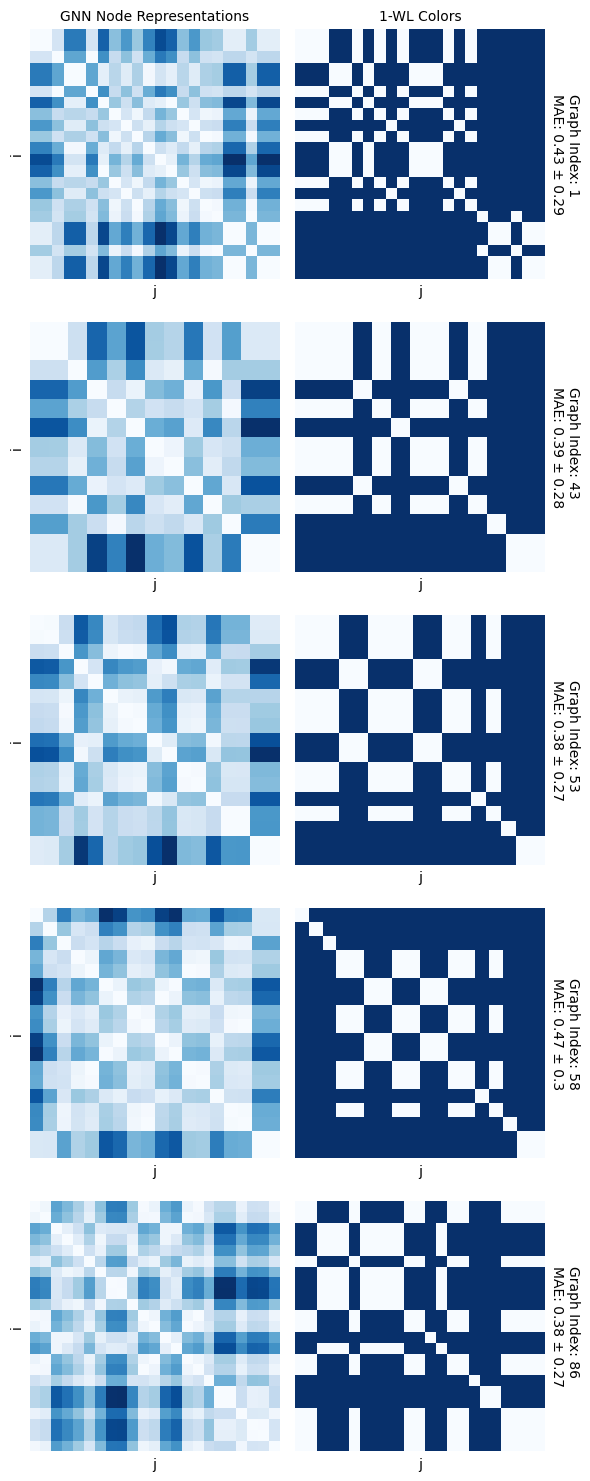

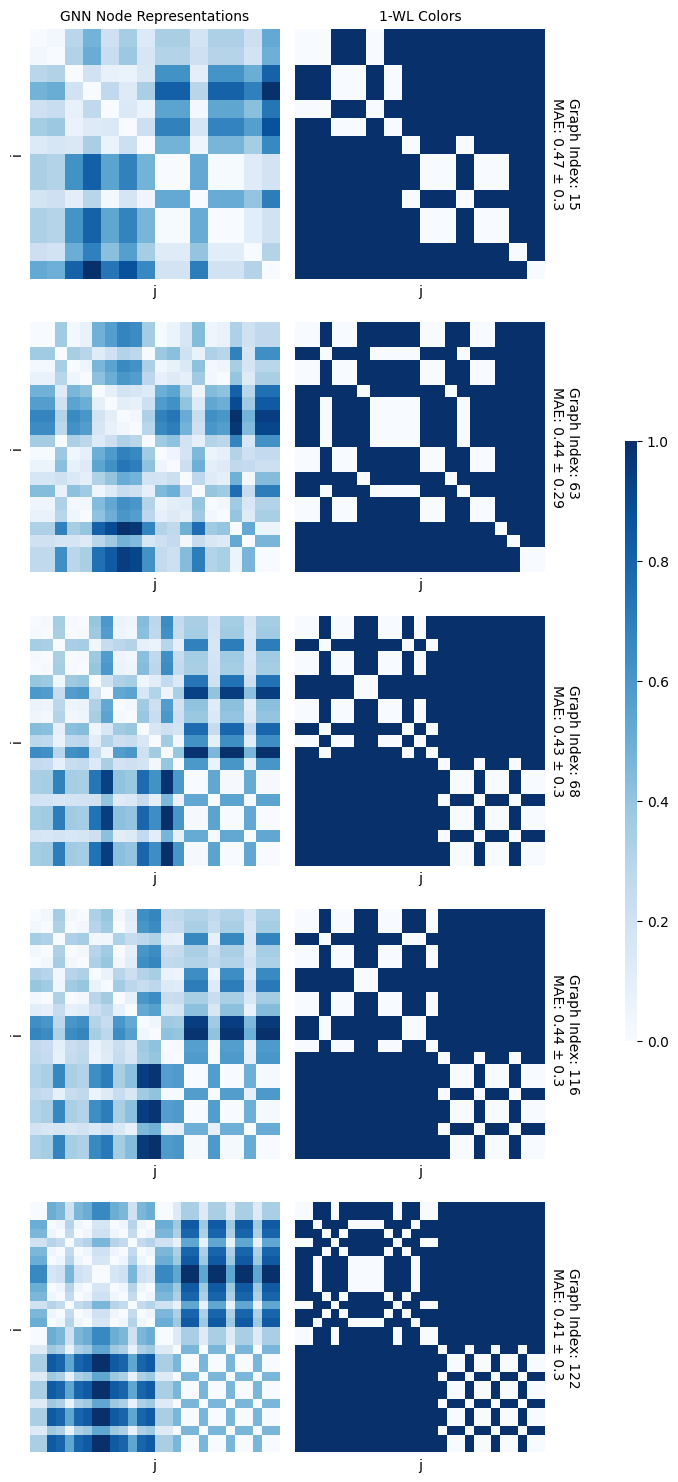

In [206]:
def facet_heatmap(data, color, **kwargs):
    data = data.pivot(index="i", columns='j', values='distance')
    sns.heatmap(data, cmap='Blues', **kwargs)

index_split = [indices_graphs[:5], indices_graphs[5:]]
for i in range(2):
    data = df_dist_matrix[df_dist_matrix['idx'].isin(index_split[i])]
    g = sns.FacetGrid(data, col='type', row='normed_error', sharex='row', sharey='row', margin_titles=True)

    if i == 0:
        g.map_dataframe(facet_heatmap, cbar=False, vmin=0, vmax=1, square=True, xticklabels=False, yticklabels=False)
    else:
        cbar_ax = g.fig.add_axes([1.05, .3, .02, .4])  # <-- Create a colorbar axes
        g.map_dataframe(facet_heatmap, cbar_ax=cbar_ax, vmin=0, vmax=1, square=True, xticklabels=False, yticklabels=False)

    g.set_titles(row_template="{row_name}", col_template="{col_name}")
    
    #g.savefig(f'../Latex/Figures/heatmaps_{dataset.name}_{i}.pdf'.format(i), bbox_inches='tight')

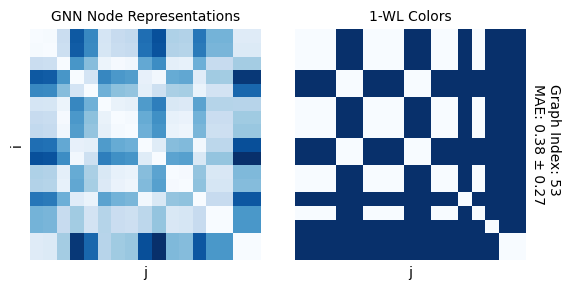

In [199]:
data = df_dist_matrix[df_dist_matrix['idx'] == test_index[torch.randint(0, len(test_index), (1,)).item()]]
g = sns.FacetGrid(data, col='type', row='normed_error', sharex='row', sharey='row', margin_titles=True)
g.map_dataframe(facet_heatmap, cbar=False, vmin=0, vmax=1, square=True, xticklabels=False, yticklabels=False)
g.set_titles(row_template="{row_name}", col_template="{col_name}")
#g.savefig(f'../Latex/Figures/heatmaps_{dataset.name}_single.pdf', bbox_inches='tight')

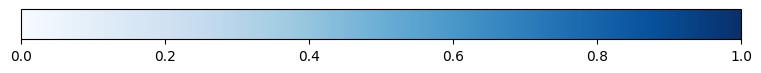

In [378]:
import pylab as pl
import numpy as np

a = np.array([[0,1]])
pl.figure(figsize=(9, 0.5))
img = pl.imshow(a, cmap="Blues")
pl.gca().set_visible(False)
cax = pl.axes([0.1, 0.2, 0.8, 0.6])
pl.colorbar(orientation="horizontal", cax=cax)
#pl.savefig("../Latex/Figures/colorbar.pdf", bbox_inches='tight')

# Clustering Metric

In [1]:
from sklearn import metrics

all_metrics = ['rand_score', 'adjusted_rand_score', 'normalized_mutual_info_score', 'adjusted_mutual_info_score',
               'homogeneity_score', 'completeness_score', 'v_measure_score', 'fowlkes_mallows_score']
def evaluate(y_pred, y_true):
    rs = metrics.rand_score(y_true, y_pred)
    ars = metrics.adjusted_rand_score(y_true, y_pred)
    nmi = metrics.normalized_mutual_info_score(y_true, y_pred)
    ami = metrics.adjusted_mutual_info_score(y_true, y_pred)
    hom = metrics.homogeneity_score(y_true, y_pred)
    com = metrics.completeness_score(y_true, y_pred)
    vms = metrics.v_measure_score(y_true, y_pred)
    fws = metrics.fowlkes_mallows_score(y_true, y_pred)


    return {'rand_score': rs, 'adjusted_rand_score': ars, 'normalized_mutual_info_score': nmi,
            'adjusted_mutual_info_score': ami, 'homogeneity_score': hom, 'completeness_score': com,
            'v_measure_score': vms, 'fowlkes_mallows_score': fws}

In [14]:
with torch.no_grad():
    x_train = []
    y_train = []

    for idx in train_index:
        x_gnn = model.gnn(dataset[idx].x, dataset[idx].edge_index)
        x_wl = wl_dataset[idx].x

        x_train.append(x_gnn)
        y_train.append(x_wl)

    x_train = torch.cat(x_train, dim=0)
    y_train = torch.cat(y_train, dim=0)

    x_test = []
    y_test = []

    for idx in test_index:
        x_gnn = model.gnn(dataset[idx].x, dataset[idx].edge_index)
        x_wl = wl_dataset[idx].x

        x_test.append(x_gnn)
        y_test.append(x_wl)

    x_test = torch.cat(x_test, dim=0)
    y_test = torch.cat(y_test, dim=0)

In [14]:
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN, OPTICS, Birch, BisectingKMeans
dist_data = []
num_cluster = len(torch.unique(y_test))

kmeans = KMeans(n_clusters=num_cluster, random_state=42, init='k-means++', n_init='auto').fit(x_test)
dist_data.append(evaluate(kmeans.labels_, y_test) | {'name': 'kmeans', 'num_cluster': num_cluster})

aggC_ward = AgglomerativeClustering(n_clusters=num_cluster, linkage='ward').fit(x_test)
dist_data.append(evaluate(aggC_ward.labels_, y_test) | {'name': 'aggC_ward', 'num_cluster': num_cluster})

aggC_avg = AgglomerativeClustering(n_clusters=num_cluster, linkage='average').fit(x_test)
dist_data.append(evaluate(aggC_avg.labels_, y_test) | {'name': 'aggC_avg', 'num_cluster': num_cluster})

dbscan = DBSCAN(eps=0.5, min_samples=5).fit(x_test)
dist_data.append(evaluate(dbscan.labels_, y_test) | {'name': 'dbscan', 'num_cluster': num_cluster})

optics = OPTICS(min_samples=5).fit(x_test)
dist_data.append(evaluate(optics.labels_, y_test) | {'name': 'optics', 'num_cluster': num_cluster})

birch = Birch(n_clusters=num_cluster).fit(x_test)
dist_data.append(evaluate(birch.labels_, y_test) | {'name': 'birch', 'num_cluster': num_cluster})

bisectingKmeans = BisectingKMeans(n_clusters=num_cluster).fit(x_test)
dist_data.append(evaluate(bisectingKmeans.labels_, y_test) | {'name': 'bisectingKmeans', 'num_cluster': num_cluster})

df_cluster_metrics = pd.DataFrame(dist_data)

In [19]:
df_cluster_metrics

,rand_score,adjusted_rand_score,normalized_mutual_info_score,adjusted_mutual_info_score,homogeneity_score,completeness_score,v_measure_score,fowlkes_mallows_score,name,num_cluster
0,0.966394,0.297932,0.687398,0.613401,0.780458,0.614167,0.687398,0.367233,kmeans,149
1,0.966792,0.292508,0.710801,0.640931,0.812982,0.631438,0.710801,0.369268,aggC_ward,149
2,0.948761,0.340135,0.653657,0.592979,0.655570,0.651755,0.653657,0.367724,aggC_avg,149
3,0.209294,0.014530,0.146240,0.130254,0.080907,0.759746,0.146240,0.208999,dbscan,149
4,0.635521,-0.000065,0.423289,0.258958,0.374406,0.486854,0.423289,0.114880,optics,149
5,0.955879,0.296869,0.617139,0.546602,0.641659,0.594424,0.617139,0.322979,birch,149
6,0.964425,0.242018,0.651642,0.568485,0.743872,0.579759,0.651642,0.308943,bisectingKmeans,149


In [37]:
with torch.no_grad():
    x_train = []
    y_train = []

    for idx in train_index:
        x_gnn = model.gnn(dataset[idx].x, dataset[idx].edge_index)
        x_gnn = model.pool(x_gnn, dataset[idx].batch)
        x_wl = dataset[idx].y

        x_train.append(x_gnn)
        y_train.append(x_wl)

    x_train = torch.cat(x_train, dim=0)
    y_train = torch.cat(y_train, dim=0)

    x_test = []
    y_test = []

    for idx in test_index:
        x_gnn = model.gnn(dataset[idx].x, dataset[idx].edge_index)
        x_gnn = model.pool(x_gnn, dataset[idx].batch)
        x_wl = dataset[idx].y

        x_test.append(x_gnn)
        y_test.append(x_wl)

    x_test = torch.cat(x_test, dim=0)
    y_test = torch.cat(y_test, dim=0)

# KNN

In [21]:
knn_runs = ['o84jwl99', 'r0hzi69w', 'hsoebyq6', 'h41v1r4j', '9c64l23v', 'ircwl3vt', 'xwp3x7vc', 'nor2tequ', 'vvw0t1se', 'tku7invn']

df_knn = pd.DataFrame()
api = wandb.Api()
runs = api.runs("eric-bill/BachelorThesisExperiments")

for run in runs:
    if run.state == "finished" and run.id in knn_runs:

        knn = run.history(keys=['k', 'knn_accuracies', 'knn_accuracies_std'])
        knn['dataset'] = run.config['dataset']
        knn['model_type'] = get_model_type(run.config['model'])
        knn['test_accuracy'] = run.summary['test_accuracy']
        knn['run_id'] = run.id

        df_knn = pd.concat([df_knn, knn], ignore_index=True)

df_knn

,_step,k,knn_accuracies,knn_accuracies_std,dataset,model_type,test_accuracy,run_id
0,0,1,85.742690,7.896076,MUTAG,GNN,83.350876,tku7invn
1,1,2,81.923977,9.387200,MUTAG,GNN,83.350876,tku7invn
2,2,3,83.988304,8.453578,MUTAG,GNN,83.350876,tku7invn
3,3,4,84.508772,7.569330,MUTAG,GNN,83.350876,tku7invn
4,4,5,85.035088,7.356859,MUTAG,GNN,83.350876,tku7invn
...,...,...,...,...,...,...,...,...
1895,195,196,25.800000,5.283783,ENZYMES,1-WL+NN,47.866665,o84jwl99
1896,196,197,25.466667,5.281637,ENZYMES,1-WL+NN,47.866665,o84jwl99
1897,197,198,25.633333,5.280027,ENZYMES,1-WL+NN,47.866665,o84jwl99
1898,198,199,25.366667,5.576615,ENZYMES,1-WL+NN,47.866665,o84jwl99


In [44]:
pivot_knn = get_acc_and_std(df_knn, group_col=['model_type','dataset'], acc_col='knn_accuracies', std_col='k', latex=False)
pivot_knn.pivot_table(index=['model_type'], columns=['dataset'], values=['knn_accuracies'], aggfunc=lambda x: x)

knn_accuracies                                                    
dataset           ENZYMES   IMDB-BINARY        MUTAG        NCI1     PROTEINS
model_type                                                                   
1-WL+NN        56.3 ± 1.0   72.3 ± 11.0  86.7 ± 10.0  83.9 ± 5.0  73.9 ± 19.0
GNN            51.6 ± 1.0  74.3 ± 132.0  88.3 ± 38.0  77.5 ± 2.0  74.9 ± 27.0

/var/folders/gk/0jn5z2112g5b638tcpy_xs980000gn/T/ipykernel_1709/538782078.py:29: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.axes[0].set_yticklabels([f'{int(y) if y.is_integer() else y}%' for y in g.axes[0].get_yticks()])


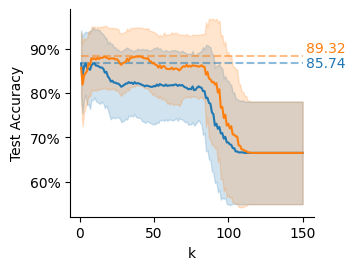

In [211]:
def plot_knn(data, x, y, std, **kwargs):
    y_max = data[y].max()
    data_max = pd.DataFrame({'max': [y_max] * len(data), x: data[x]})
    sns.lineplot(data_max, x=x, y='max', color=kwargs['color'], alpha=0.5, linestyle='--')

    line = sns.lineplot(data=data, x=x, y=y, **kwargs)

    # Fix if the text is to close togehter
    if y_max < 88.3:
        y_max -= 1
    else:
        y_max += 1
    
    line.axes.text(data[x].max() + 2, y_max, f"{round(y_max, 2)}", color=kwargs['color'])
    line.fill_between(data[x], data[y] - data[std], data[y] + data[std], alpha=0.2, color=kwargs['color'])

    # y_max = data['test_accuracy'].max()
    # data_max = pd.DataFrame({'max': [y_max] * len(data), x: data[x]})
    # sns.lineplot(data_max, x=x, y='max', color='black', alpha=0.5, linestyle='-')
    # line.axes.text(data[x].max() + 2, y_max, f"{round(y_max, 2)}")

for dataset_name in ['MUTAG']:#df_knn.dataset.unique():

    g = sns.FacetGrid(df_knn[df_knn['dataset'] == dataset_name], col='dataset', hue='model_type', col_wrap=3, hue_order=['1-WL+NN', 'GNN'], margin_titles=True, sharex=False, sharey=False)
    g.map_dataframe(plot_knn, x='k', y='knn_accuracies', std='knn_accuracies_std', legend=None)
    #g.add_legend(frameon=True)
    g.set_titles(col_template="", row_template="")
    g.set_axis_labels("k", "Test Accuracy")
    g.axes[0].set_yticklabels([f'{int(y) if y.is_integer() else y}%' for y in g.axes[0].get_yticks()])

    #sns.move_legend(g, "center right", bbox_to_anchor=(1.05, 0.5), title='Model Types')

    #g.savefig(f'../LaTeX/Figures/knn_{dataset_name}.pdf', bbox_inches='tight')
    plt.show()

# SVM Viz

In [178]:
dataset_name = 'MUTAG'

wlnn_name = "1-WL+NN: 86.4% Accuracy"
gnn_name = "GNN: 51.9% Accuracy"
model = torch.load(f'saved_models/GNN_{dataset_name}.pt')

In [179]:
def calc_svm_boundary_contour(X, Y, n_points=5, **kwargs):
    clf = SVC(kernel='linear', **kwargs)
    clf.fit(X, Y)

    # Create a grid of points
    x_min = np.min(X.T, axis=1)
    x_max = np.max(X.T, axis=1)
    h = (x_max - x_min) / n_points

    arr_arange = [np.arange(x_min[i], x_max[i], h[i]) for i in range(len(x_min))]
    xx = np.meshgrid(*arr_arange)
    xx = np.hstack([dim.reshape(-1, 1) for dim in np.meshgrid(*arr_arange)])

    # Calculate the decision values for the grid points
    Z = clf.predict(xx)
        
    return pd.DataFrame({'x': xx[:, 0], 'y': xx[:, 1], 'class': Z})

In [180]:
model_gnn = torch.load(f'saved_models/GNN_{dataset_name}.pt')
X_gnn = model_gnn.data_aggregate[:, :-1]
Y_gnn = model_gnn.data_aggregate[:, -1]

X_gnn = TSNE(n_components=2).fit_transform(X_gnn)

df_gnn = pd.DataFrame(X_gnn, columns=['x', 'y'])
df_gnn['class'] = Y_gnn
df_gnn['model_type'] = gnn_name
df_gnn['scatter'] = 1

df_svm = calc_svm_boundary_contour(X_gnn, Y_gnn, n_points=100)
df_svm['model_type'] = gnn_name
df_svm['scatter'] = 0

df_gnn = pd.concat([df_gnn, df_svm])

model_wlnn = torch.load(f'saved_models/WLNN_{dataset_name}.pt')
X_wlnn = model_wlnn.data_aggregate[:, :-1]
Y_wlnn = model_wlnn.data_aggregate[:, -1]

X_wlnn = TSNE(n_components=2).fit_transform(X_wlnn)

df_wlnn = pd.DataFrame(X_wlnn, columns=['x', 'y'])
df_wlnn['class'] = Y_wlnn
df_wlnn['model_type'] = wlnn_name
df_wlnn['scatter'] = 1

df_svm = calc_svm_boundary_contour(X_wlnn, Y_wlnn, n_points=100)
df_svm['model_type'] = wlnn_name
df_svm['scatter'] = 0

df_wlnn = pd.concat([df_wlnn, df_svm])

df_svm = pd.concat([df_gnn, df_wlnn])

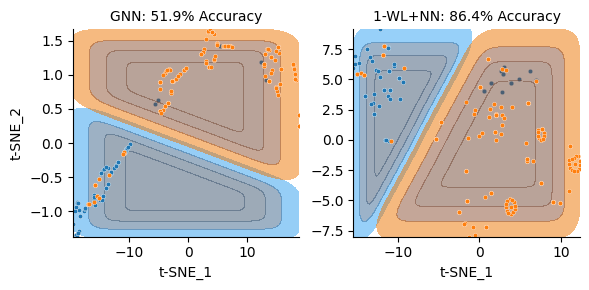

In [181]:
def custom_plotter(data, x, y, **kwargs):
    sns.kdeplot(data=data[data['scatter'] == 0], x=x, y=y, levels=5, alpha=0.5, fill=True, thresh=0.1, **kwargs)
    sns.scatterplot(data=data[data['scatter'] == 1], x=x, y=y, s=10, **kwargs)

g = sns.FacetGrid(df_svm, col='model_type', hue='class', margin_titles=True, sharex=False, sharey=False)
g.map_dataframe(custom_plotter, x='x', y='y')

g.set_titles(col_template="{col_name}", row_template="{row_name}")
#g.add_legend(title='Class Label', frameon=True, ncol=2)
g.set_axis_labels(f't-SNE_1', f't-SNE_2')

x_min_gnn, y_min_gnn = df_svm[df_svm['model_type'] == gnn_name][['x', 'y']].min()
x_max_gnn, y_max_gnn = df_svm[df_svm['model_type'] == gnn_name][['x', 'y']].max()

g.axes[0, 0].set_xlim(x_min_gnn, x_max_gnn)
g.axes[0, 0].set_ylim(y_min_gnn, y_max_gnn)

x_min_wlnn, y_min_wlnn = df_svm[df_svm['model_type'] == wlnn_name][['x', 'y']].min()
x_max_wlnn, y_max_wlnn = df_svm[df_svm['model_type'] == wlnn_name][['x', 'y']].max()
g.axes[0, 1].set_xlim(x_min_wlnn, x_max_wlnn)
g.axes[0, 1].set_ylim(y_min_wlnn, y_max_wlnn)

#g.savefig(f'../LaTeX/figures/tsne_svm_lin_{dataset_name}.pdf', bbox_inches='tight')

# Quantil

In [45]:
x = [[1, 2], [5, 2], [10, 8], [50, 3]]
data = pd.DataFrame(x, columns=['q', 'res'])

In [123]:
def calc_quantil_performance(dataframe, grouping_columns, quantils):
    rows = []

    for (grouping_values, grouped_dataframe) in dataframe.groupby(grouping_columns):
        for q in quantils:
            index = grouped_dataframe.index[grouped_dataframe['test_accuracy'] >= grouped_dataframe['test_accuracy'].quantile(1 - q, interpolation='lower')]
            grouping_info = {column: value for column, value in zip(grouping_columns, grouping_values)}
            
            for i in index:
                rows.append({'Quantile' : f'{int(q*100)}%', 'train_accuracy' : dataframe.loc[i]['train_accuracy'],
                             'val_accuracy' : dataframe.loc[i]['val_accuracy'], 'test_accuracy' : dataframe.loc[i]['test_accuracy'],
                            } | grouping_info)

    return pd.DataFrame(rows)

In [124]:
df_qunatil = calc_quantil_performance(runs_df, ['dataset', 'model_type'], quantils=[0.01, 0.05, 0.10, 0.25, 0.5, 1.0])
df_qunatil['difference'] = df_qunatil['train_accuracy'] - df_qunatil['test_accuracy']

/var/folders/gk/0jn5z2112g5b638tcpy_xs980000gn/T/ipykernel_1709/3835903218.py:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([f'{int(y) if y.is_integer() else y}%' for y in ax.get_yticks()])


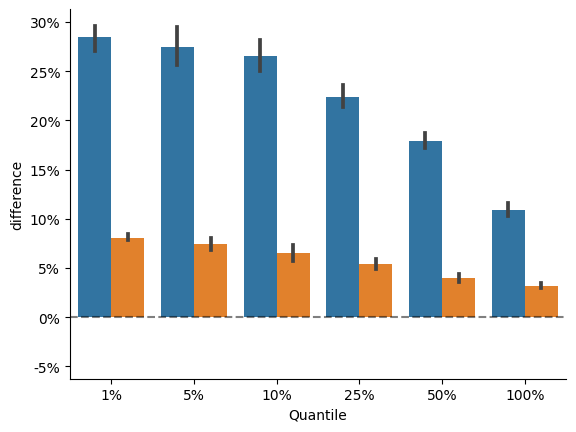

/var/folders/gk/0jn5z2112g5b638tcpy_xs980000gn/T/ipykernel_1709/3835903218.py:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([f'{int(y) if y.is_integer() else y}%' for y in ax.get_yticks()])


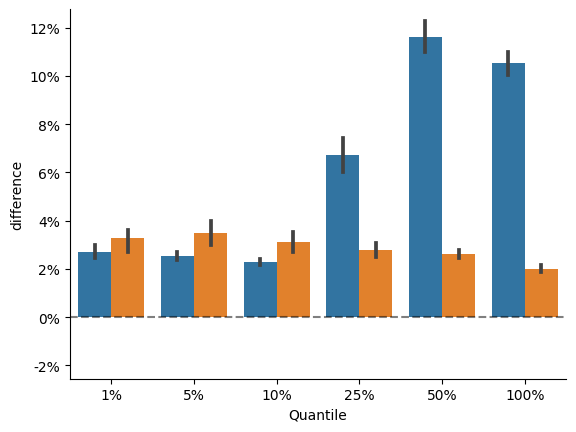

/var/folders/gk/0jn5z2112g5b638tcpy_xs980000gn/T/ipykernel_1709/3835903218.py:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([f'{int(y) if y.is_integer() else y}%' for y in ax.get_yticks()])


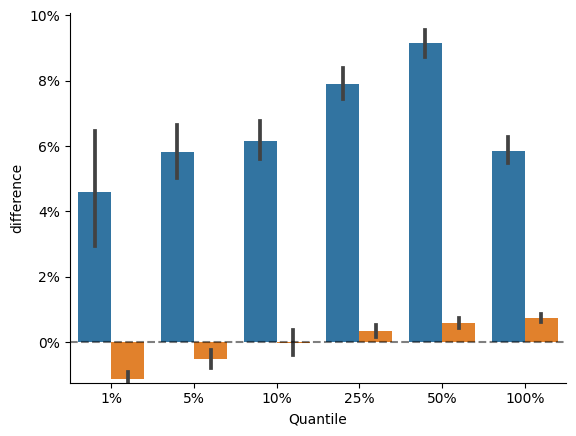

/var/folders/gk/0jn5z2112g5b638tcpy_xs980000gn/T/ipykernel_1709/3835903218.py:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([f'{int(y) if y.is_integer() else y}%' for y in ax.get_yticks()])


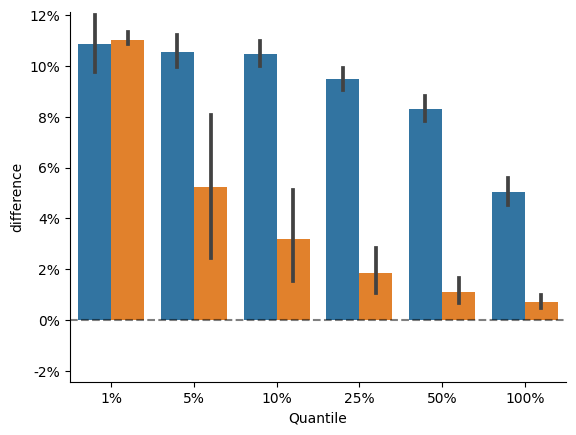

/var/folders/gk/0jn5z2112g5b638tcpy_xs980000gn/T/ipykernel_1709/3835903218.py:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([f'{int(y) if y.is_integer() else y}%' for y in ax.get_yticks()])


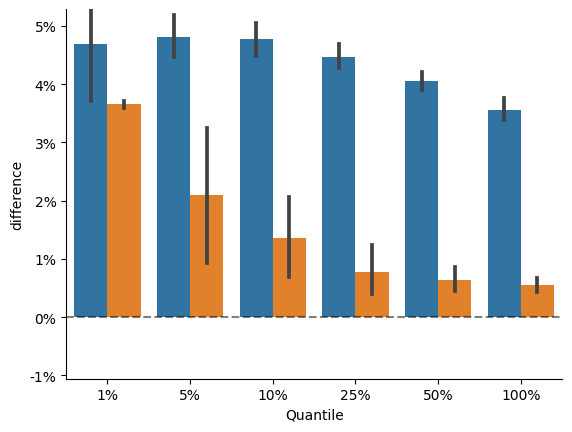

/var/folders/gk/0jn5z2112g5b638tcpy_xs980000gn/T/ipykernel_1709/3835903218.py:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([f'{int(y) if y.is_integer() else y}%' for y in ax.get_yticks()])


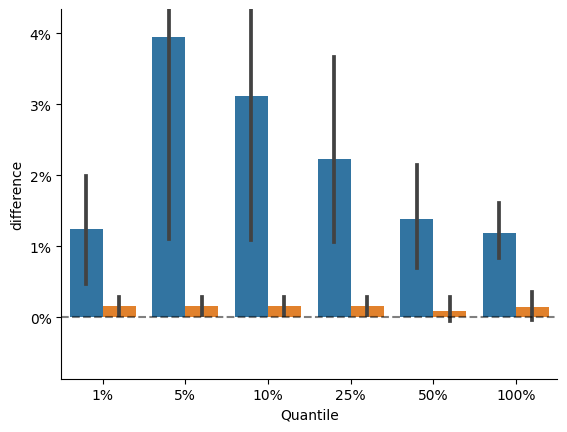

In [152]:
for dataset_name in df_qunatil['dataset'].unique():
    df = df_qunatil[df_qunatil['dataset'] == dataset_name]

    ax = sns.barplot(df, x='Quantile', y='difference', hue='model_type', hue_order=['1-WL+NN', 'GNN'], estimator='mean')
    sns.despine(bottom = False, left = False)

    #bar.set_title('Absolute Difference in Classification Accuracies between Training and Testing')


    y_max = df[['difference', 'Quantile', 'model_type']].groupby(['Quantile', 'model_type']).mean().max().abs().item()
    y_min = df[['difference', 'Quantile', 'model_type']].groupby(['Quantile', 'model_type']).mean().min().item()

    if y_min > 0:
        y_min = - 0.2 * y_max

    ax.set_ylim([1.1* y_min, 1.1 * y_max])

    ax.set_yticklabels([f'{int(y) if y.is_integer() else y}%' for y in ax.get_yticks()])

    ax.axhline(0.0, color='black', linestyle='--', alpha=0.5, snap=True)
    ax.legend_.remove()

    fig = ax.get_figure()
    #fig.savefig(f'../LaTeX/figures/train_test_diff_{dataset_name}.pdf', bbox_inches='tight')

    plt.show()

In [159]:
import pylab

fig = pylab.figure()

figlegend = pylab.figure(figsize=(3,2))
figlegend.legend(ax.get_legend_handles_labels()[0], ax.get_legend_handles_labels()[1], ncol=2)
figlegend.show()
figlegend.savefig(f'../LaTeX/figures/train_test_diff_legend.pdf', bbox_inches='tight')


/var/folders/gk/0jn5z2112g5b638tcpy_xs980000gn/T/ipykernel_1709/211676164.py:7: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  figlegend.show()


<Figure size 640x480 with 0 Axes>

<Figure size 300x200 with 0 Axes>

# Unbalanceness

In [8]:
dataset = torch_geometric.datasets.TUDataset(root=f"datasets", name="PROTEINS").shuffle()
dataset.y.unique(sorted=False, return_counts=True)

(tensor([1, 0]), tensor([450, 663]))

In [4]:
dataset_list = ["ENZYMES", "PROTEINS", "IMDB-BINARY", "IMDB-MULTI", "NCI1", "MUTAG", "REDDIT-BINARY", "REDDIT-MULTI-5K"]

data = []
for dataset_name in dataset_list:
    dataset = torch_geometric.datasets.TUDataset(root=f"datasets", name=dataset_name).shuffle()
    unbalance = utils.calc_shannon_diversity(dataset)
    data.append([dataset_name, unbalance])

clear_output()
df_unbalances = pd.DataFrame(data, columns=["dataset", "shannon_diversity"])
df_unbalances.pivot_table(columns="dataset", values="shannon_diversity")

dataset,ENZYMES,IMDB-BINARY,IMDB-MULTI,MUTAG,NCI1,PROTEINS,REDDIT-BINARY,REDDIT-MULTI-5K
shannon_diversity,1.0,1.0,1.0,0.92,1.0,0.973,1.0,1.0


In [55]:
api = wandb.Api(timeout=30)

# Project is specified by <entity/project-name>
runs = api.runs("eric-bill/BachelorThesisExperiments")

dist_data = []
for run in runs:
    if run.state == "finished" and ': Theoretical Accuracy' in run.name:
        history = run.history()
        history.sort_values(by='k_wl', ascending=True, inplace=True)

        row = f'& {run.config["dataset"]} '
        last_acc = 0.0
        for acc in history['max_acc']:
            if acc > last_acc:
                row += f'& {acc:.2f} '
            else:
                row += f'& - '
            last_acc = acc
        row += '\\\\'
        print(row)

& FRANKENSTEIN & 0.63 & 0.77 & 0.88 & 0.89 & 0.89 & - \\
& Peking_1 & 1.00 & - & - & - & - & - \\
& KKI & 1.00 & - & - & - & - & - \\
& AIDS & 1.00 & 1.00 & - & - & - & - \\
& OHSU & 1.00 & - & - & - & - & - \\
& DHFR & 0.92 & 0.95 & 1.00 & 1.00 & - & - \\
& BZR & 0.96 & 0.99 & 1.00 & - & - & - \\
& COX2 & 0.93 & 0.96 & 0.99 & 1.00 & - & - \\
& NCI109 & 0.92 & 1.00 & 1.00 & 1.00 & - & - \\
& REDDIT-BINARY & 0.84 & 1.00 & - & - & - & - \\
& PTC_MR & 0.92 & 0.98 & 0.99 & - & - & - \\
& DD & 1.00 & - & - & - & - & - \\
& COLLAB & 0.61 & 0.98 & - & - & - & - \\
& MUTAG & 0.93 & 0.96 & 0.99 & 1.00 & - & - \\
& NCI1 & 0.91 & 1.00 & 1.00 & 1.00 & - & - \\
& IMDB-MULTI & 0.44 & 0.63 & - & - & - & - \\
& IMDB-BINARY & 0.61 & 0.89 & - & - & - & - \\
& PROTEINS & 0.92 & 1.00 & - & - & - & - \\
& ENZYMES & 0.81 & 1.00 & - & - & - & - \\


In [76]:
runs_df.columns

Index(['test_error_std', 'test_error_log_std', '_step', '_wandb', '_runtime',
       '_timestamp', 'test_error', 'test_error_log', 'act', 'k_wl', 'norm',
       'model', 'dataset', 'dropout', 'num_layers', 'embedding_dim',
       'wl_convergence', 'config', 'Tags', 'name', 'run_id', 'tags',
       'mlp_kwargs', 'encoding_kwargs', 'num_epochs', 'num_epochs_std',
       'train_accuracy_std', 'val_accuracy', 'test_accuracy', 'train_accuracy',
       'val_accuracy_std', 'test_accuracy_std', 'jk', 'lr', 'seed', 'device',
       'k_fold', 'act_first', 'batch_size', 'gnn_kwargs', 'max_epochs',
       'num_repition', 'hidden_channels', 'svm_rbf_accuracies',
       'svm_lin_accuracies_std', 'svm_rbf_accuracies_std', 'knn_accuracies',
       'knn_accuracies_std', 'svm_lin_accuracies', 'k', 'pca', 'tsne',
       'max_accuracy', 'knn', 'transformer_kwargs', 'Shannon Diversity',
       '1-WL Accuracy', 'dataset_names', 'wl_max_iterations', 'model_type',
       'pool_type'],
      dtype='object')

In [102]:
ds_list = ['ENZYMES', 'PROTEINS', 'IMDB-BINARY', 'NCI1', 'MUTAG', 'REDDIT-BINARY']
ds_list.sort()
ds_list

['ENZYMES', 'IMDB-BINARY', 'MUTAG', 'NCI1', 'PROTEINS', 'REDDIT-BINARY']

In [148]:
k_wl_df

,k_wl,dataset,test_accuracy
0,1.0,Alchemy10K,NaN
1,1.0,ENZYMES,27.542541
2,1.0,IMDB-BINARY,66.203950
3,1.0,MUTAG,74.068468
4,1.0,NCI1,66.258415
5,1.0,PROTEINS,70.147000
6,1.0,REDDIT-BINARY,64.652841
7,1.0,Zinc,NaN
8,1.0,Zinc 10k,NaN
9,2.0,Alchemy10K,NaN


In [151]:
k_wl_df



,k_wl,dataset,test_accuracy
0,1.0,Alchemy10K,NaN
1,1.0,ENZYMES,27.542541
2,1.0,IMDB-BINARY,66.203950
3,1.0,MUTAG,74.068468
4,1.0,NCI1,66.258415
5,1.0,PROTEINS,70.147000
6,1.0,REDDIT-BINARY,64.652841
7,1.0,Zinc,NaN
8,1.0,Zinc 10k,NaN
9,2.0,Alchemy10K,NaN


In [195]:
g.axes[0, 0]

<Axes: xlabel='Number of 1-WL Iterations', ylabel='Test Accuracy'>

/var/folders/gk/0jn5z2112g5b638tcpy_xs980000gn/T/ipykernel_95123/2086039469.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.axes[0, 0].set_yticklabels([f'{int(y) if y.is_integer() else y}%' for y in g.axes[0, 0].get_yticks()])
/var/folders/gk/0jn5z2112g5b638tcpy_xs980000gn/T/ipykernel_95123/2086039469.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.axes[0, 0].set_yticklabels([f'{int(y) if y.is_integer() else y}%' for y in g.axes[0, 0].get_yticks()])
/var/folders/gk/0jn5z2112g5b638tcpy_xs980000gn/T/ipykernel_95123/2086039469.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.axes[0, 0].set_yticklabels([f'{int(y) if y.is_integer() else y}%' for y in g.axes[0, 0].get_yticks()])
/var/folders/gk/0jn5z2112g5b638tcpy_xs980000gn/T/ipykernel_95123/2086039469.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.axes[0, 0].set_yticklabels([f'{int(y) if y.

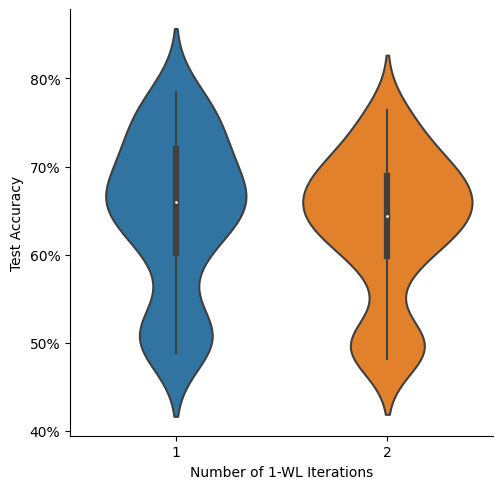

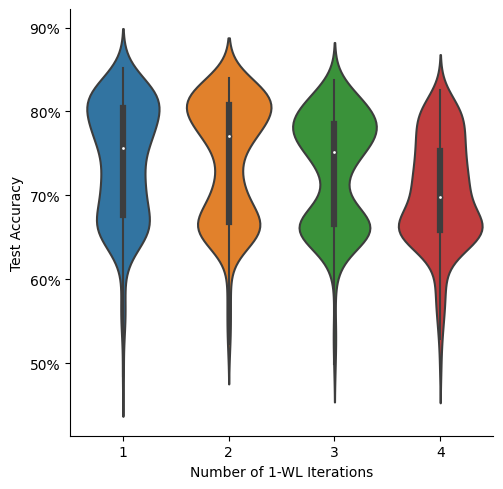

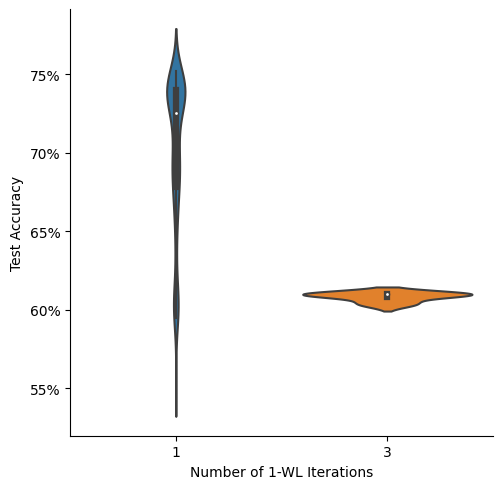

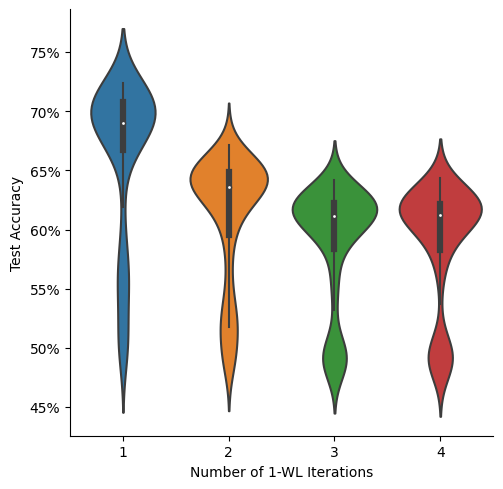

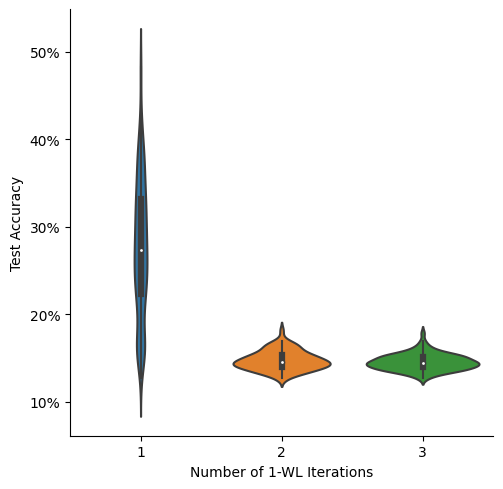

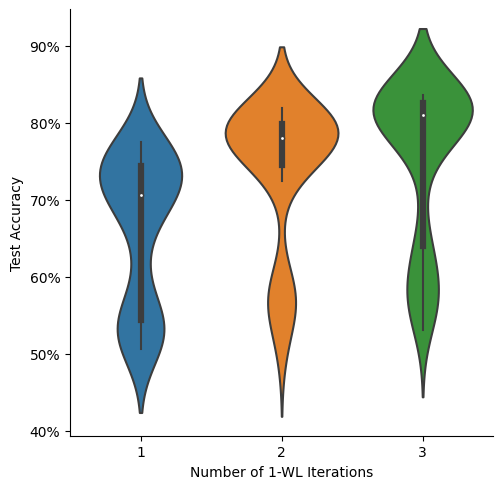

In [196]:
k_wl_df = runs_df[runs_df['model_type'] == '1-WL+NN'][['k_wl', 'dataset', 'test_accuracy']].reset_index()
k_wl_df['k_wl'] = k_wl_df['k_wl'].astype(int)
k_wl_df.dropna(inplace=True)

for ds in k_wl_df['dataset'].unique():
    g = sns.catplot(data=k_wl_df[k_wl_df['dataset'] == ds], y='test_accuracy', x='k_wl', kind='violin')
    g.set_titles('{col_name}')
    g.set_ylabels('Test Accuracy')
    g.set_xlabels('Number of 1-WL Iterations')
    g.axes[0, 0].set_yticklabels([f'{int(y) if y.is_integer() else y}%' for y in g.axes[0, 0].get_yticks()])

    g.savefig(f'../LaTeX/figures/k_wl_violin_{ds}.pdf', bbox_inches='tight')

/var/folders/gk/0jn5z2112g5b638tcpy_xs980000gn/T/ipykernel_95123/3831054847.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.axes[0, 0].set_yticklabels([f'{round(y, 2)}%' for y in g.axes[0, 0].get_yticks()])
/var/folders/gk/0jn5z2112g5b638tcpy_xs980000gn/T/ipykernel_95123/3831054847.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.axes[0, 0].set_yticklabels([f'{round(y, 2)}%' for y in g.axes[0, 0].get_yticks()])
/var/folders/gk/0jn5z2112g5b638tcpy_xs980000gn/T/ipykernel_95123/3831054847.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.axes[0, 0].set_yticklabels([f'{round(y, 2)}%' for y in g.axes[0, 0].get_yticks()])
/var/folders/gk/0jn5z2112g5b638tcpy_xs980000gn/T/ipykernel_95123/3831054847.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.axes[0, 0].set_yticklabels([f'{round(y, 2)}%' for y in g.axes[0, 0].get_yticks()])


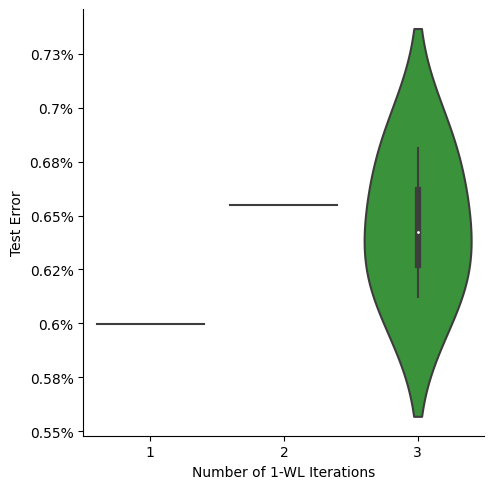

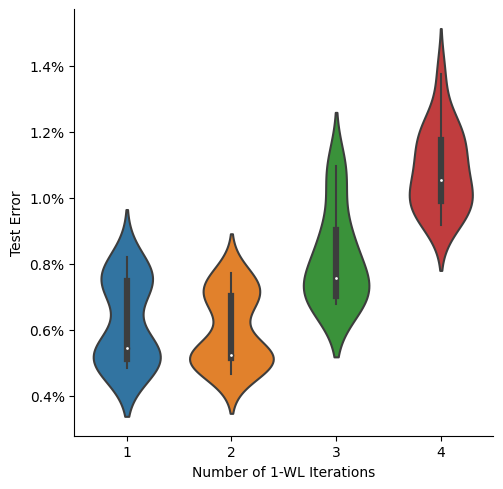

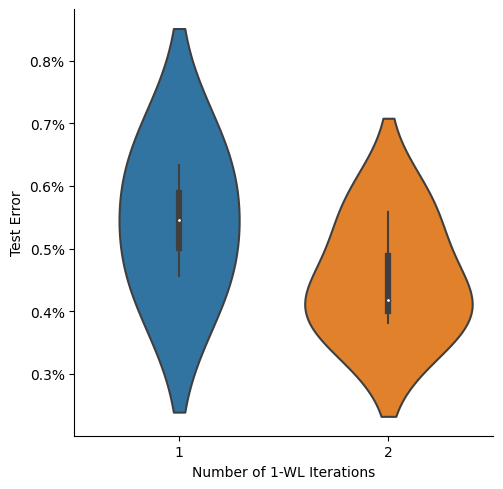

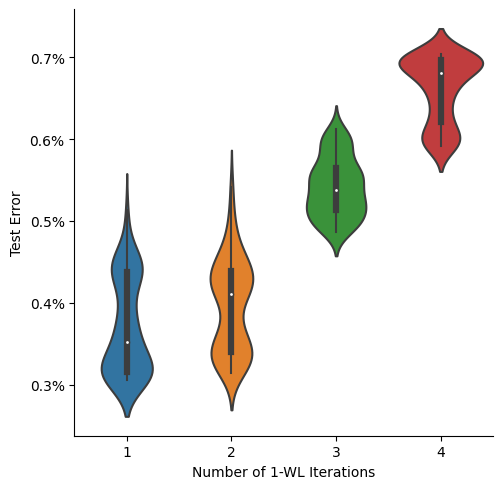

In [219]:
k_wl_df = runs_df[runs_df['model_type'] == '1-WL+NN'][['k_wl', 'dataset', 'test_error']].reset_index()
k_wl_df['k_wl'] = k_wl_df['k_wl'].astype(int)
k_wl_df.dropna(inplace=True)

for ds in k_wl_df['dataset'].unique():
    g = sns.catplot(data=k_wl_df[k_wl_df['dataset'] == ds], y='test_error', x='k_wl', kind='violin')
    g.set_titles('{col_name}')
    g.set_ylabels('Test Error')
    g.set_xlabels('Number of 1-WL Iterations')
    g.axes[0, 0].set_yticklabels([f'{round(y, 2)}%' for y in g.axes[0, 0].get_yticks()])

    g.savefig(f'../LaTeX/figures/k_wl_violin_{ds}.pdf', bbox_inches='tight')